# Download the data

In [2]:
%%bash
([ -f  MNIST_synthetic.h5 ] && echo "MNIST_synthetic.h5 dataset exists") ||
([ -f  MNIST_synthetic_data.zip ] && echo "zip file exists, don't download it again" ||
  (wget -nv https://github.com/patrickiskandar/MNIST_Digits_Recognition/raw/main/MNIST_synthetic_data.zip &&
  echo "data set downloaded...") &&
  unzip MNIST_synthetic_data.zip)

MNIST_synthetic.h5 dataset exists


In [2]:
import h5py
import pandas as pd
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam,RMSprop,Adadelta
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from random import randint
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read Data

In [3]:
file=h5py.File('MNIST_synthetic.h5', 'r')
print(list(file.keys()))
train=np.array(file['train_dataset']).reshape(-1, 64, 64)
test=np.array(file['test_dataset']).reshape(-1, 64, 64)
train_labels=np.array(file['train_labels'])

['mydataset', 'test_dataset', 'train_dataset', 'train_labels']


train dataset size is:(56000, 64, 64)
test dataset size is:(14000, 64, 64)
label dataset size is:(56000, 5)



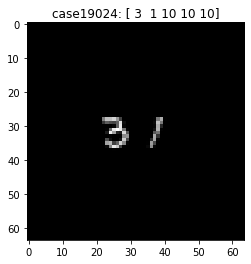

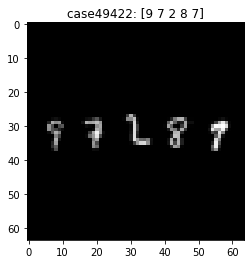

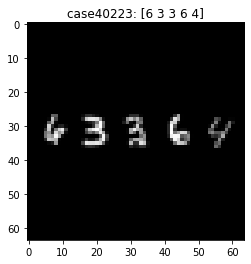

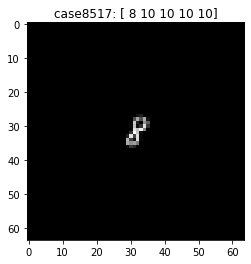

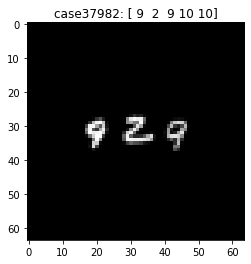

In [4]:
print(f"train dataset size is:{train.shape}\n"
      f"test dataset size is:{test.shape}\n"
      f"label dataset size is:{train_labels.shape}\n")
for _ in range(5):
    t = randint(0,train.shape[0]-1)
    plt.imshow(train[t], cmap='gray')
    plt.title(f"case{t}: {train_labels[t]}")
    plt.show()

# Preprocess

> NOTE(Please mention this in DOC): \
> this is not good to use this line:\
> `np.any(img, axis=0).astype(np.int16)`\
> because some digits are so near to each other\
> in order to avoid noise lets use this line:\
> `np.mean(img, axis=0).astype(np.int16)`

In [5]:
t = np.array([1,2,3,0,0,1,2])
t[t>0] -= t[t>0].min()
t

array([0, 1, 2, 0, 0, 0, 1])

instance number 2684


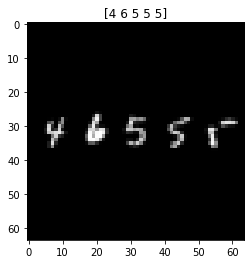

After spliting digits we have:


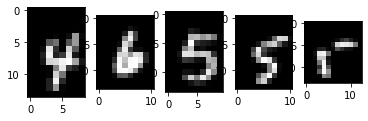

In [6]:
def findDiffs(img,margin):
  col,row = img.shape
  col_mean = np.mean(img, axis=0).astype(np.int16)
  row_mean = np.mean(img, axis=1).astype(np.int16)
  col_mean[col_mean>0] = 1
  row_mean[row_mean>0] = 1
  col_diff = np.diff(col_mean)
  row_diff = np.diff(row_mean)
  startRow = max(0, np.where(row_diff>0)[0][0]-margin)
  endRow = min(row, np.where(row_diff<0)[0][-1]+margin)
  opening_indices = np.where(col_diff>0)[0]
  closing_indices = np.where(col_diff<0)[0]
  return startRow, endRow, opening_indices, closing_indices, col_diff

def padImage(img,n,m):
  z = np.zeros((n,m),dtype=np.uint8)
  z[(n-img.shape[0])//2:(n+img.shape[0])//2,(m-img.shape[1])//2:(m+img.shape[1])//2] = img
  return z

def splitDigits(img, digitsLabel=[], m=None, n=None,margin=2,binary_output = False):
  img = img.copy().astype(np.uint8)
  col,row = img.shape
  assert (img>=0).all()
  startRow, endRow, opening_indices, closing_indices, col_diff = findDiffs(img,margin=margin)
#     col_startPoint = np.where(diff>0)
#     col_endPoint = np.where(diff>0)
  # print(col_mean)
  # print(normImg)
  digitsCount = len([i for i in digitsLabel if i!=10]) or opening_indices.shape[0]

  if opening_indices.shape[0] > digitsCount:
    numberOfExtraIndices =  opening_indices.shape[0] - digitsCount
    assert numberOfExtraIndices > 0,[opening_indices,digitsLabel,digitsCount]
    # print(col_diff)
    # print(opening_indices)
    # print(closing_indices)
    for i in np.argsort(opening_indices[1:]-closing_indices[:-1])[:numberOfExtraIndices]:
      col_diff[closing_indices[i]] = 0
      try:
        col_diff[opening_indices[i+1]] = 0
      except:
        print(col_diff)
        print(opening_indices)
        print(closing_indices)
        raise
      opening_indices = np.where(col_diff>0)[0]
      closing_indices = np.where(col_diff<0)[0]
      # print(col_diff)
    assert opening_indices.shape[0] == digitsCount == closing_indices.shape[0],[opening_indices, digitsCount, closing_indices]
  elif opening_indices.shape[0] < digitsCount:
    newImg = img.copy()
    while opening_indices.shape[0] < digitsCount:
      startRow, endRow, opening_indices, closing_indices,col_diff = findDiffs(newImg,margin=margin)
      newImg[newImg>0] -= newImg[newImg>0].min()
    assert opening_indices.shape[0] == digitsCount == closing_indices.shape[0],[opening_indices, digitsCount, closing_indices]
  digits = [img[startRow:endRow,max(0,start-margin):min(col,end+margin)] \
            for start,end in zip(opening_indices,closing_indices)]
  assert all([(i>=0).all() for i in digits])
  if binary_output:
      for i,_ in enumerate(digits):
          digits[i][digits[i]!=0] = 1
  if m and n:
      digits_ = []
      for i in digits:
          digits_.append(padImage(i,n,m))
      return digits_
  return digits


TestInstance = randint(0,len(train)-1)
TestInstance = 18127
TestInstance = 2684
print(f"instance number {TestInstance}")
plt.imshow(train[TestInstance],cmap="gray")
plt.title(train_labels[TestInstance])
plt.show()
print("After spliting digits we have:")
digits = splitDigits(train[TestInstance],train_labels[TestInstance])
for i,p in enumerate(digits):
    plt.subplot(1,len(digits),i+1)
    plt.imshow(p,cmap="gray")
plt.show()

Now lets create new data and new labels

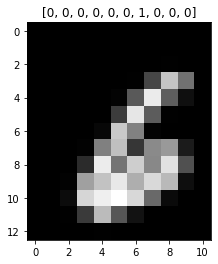

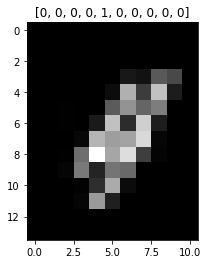

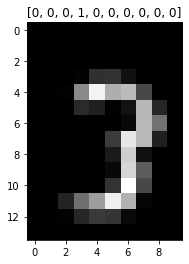

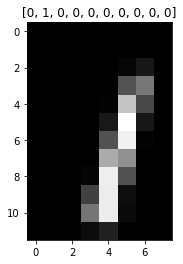

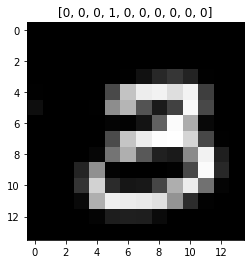

121082


In [7]:
digits_train = []
digits_labels = []
one_hot = lambda x,nb_class=10: [1 if i==x else 0 for i in range(nb_class)]
j = 0
for img,label in tqdm(zip(train,train_labels),total = len(train)):
  if j==40385: continue
  label = [one_hot(i) for i in label if i!=10]
  digits_labels += label
  try:
    digits = splitDigits(img,label)
    assert all([j.shape[0]>0 and j.shape[1]>1 for j in digits])
    digits_train += digits
  except:
    print(j)
    print(label)
    plt.imshow(img,cmap="gray")
    plt.show()
    # for i in digits:
    #   plt.imshow(i,cmap="gray")
    #   plt.show()
    raise
  j+=1
  if len(digits_train)>121084:
    plt.imshow(img,cmap="gray")
    print(label)
    print(j)
    print(digits_labels[j])
    plt.show()
    raise
  # digits_labels += [one_hot(i) for i in label if i!=10]
  # digits_labels += [i for i in label if i!=10]
  assert len(digits_train) == len(digits_labels),[len(digits_train), len(digits_labels),j]
  assert len(digits) == len([i for i in label if i!=10]),[len(digits),len([i for i in label if i!=10])]

TestNumbers = [randint(0,len(digits_labels)) for _ in range(5)]
for index,data in enumerate(TestNumbers):
  # plt.subplot(len(TestNumbers),1,index+1)
  plt.imshow(digits_train[data],cmap="gray")
  plt.title(digits_labels[data])
  plt.show()
print(len(digits_labels))

now lets make all images same size

In [8]:
sizes = np.array([i.shape for i in digits_train])
maxWidth = sizes[:,1].max()
maxHeight = sizes[:,0].max()
digits_train = np.array([padImage(i,maxHeight,maxWidth) for i in tqdm(digits_train)])
digits_labels = np.array(digits_labels)
print(digits_train.shape)
print(digits_labels.shape)


(121082, 16, 16)
(121082, 10)


Now lets devide dataset into train and validation dataset

In [9]:
trainDataSize = int(0.6*digits_train.shape[0])
xtrain = digits_train[:trainDataSize,:,:]
ytrain = digits_labels[:trainDataSize,:]
xvalid = digits_train[trainDataSize:,:,:]
yvalid = digits_labels[trainDataSize:,:]
print("xtrain shape is: ",xtrain.shape)
print("ytrain shape is: ",ytrain.shape)
print("xvalid shape is: ",xvalid.shape)
print("yvalid shape is: ",yvalid.shape)

xtrain shape is:  (72649, 16, 16)
ytrain shape is:  (72649, 10)
xvalid shape is:  (48433, 16, 16)
yvalid shape is:  (48433, 10)


In [10]:
# I have GPU :)
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(4, 4), padding="same", activation='relu', 
                 input_shape=(16, 16, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 16)        272       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          1

In [12]:
!mkdir -p savedModels
mc = ModelCheckpoint(
    "savedModels/moel_ACC:{val_accuracy}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")
model.compile(loss="categorical_crossentropy",optimizer=Adam(),metrics=['accuracy'])
model.fit(xtrain.reshape((-1,16,16,1)),ytrain,validation_data=(xvalid.reshape((-1,16,16,1)),yvalid),epochs=40,batch_size=40,callbacks=[mc])
scores = model.evaluate(xvalid.reshape((-1,16,16,1)),yvalid, verbose=1)
print(scores)

Epoch 1/40
1816/1817 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.9121
Epoch 00001: val_accuracy improved from -inf to 0.97721, saving model to savedModels/moel_ACC:0.9772056341171265.hdf5
1817/1817 [==============================] - 102s 56ms/step - loss: 0.2842 - accuracy: 0.9121 - val_loss: 0.0734 - val_accuracy: 0.9772
Epoch 2/40
1816/1817 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9623
Epoch 00002: val_accuracy improved from 0.97721 to 0.98063, saving model to savedModels/moel_ACC:0.980633020401001.hdf5
1817/1817 [==============================] - 103s 57ms/step - loss: 0.1240 - accuracy: 0.9623 - val_loss: 0.0661 - val_accuracy: 0.9806
Epoch 3/40
 955/1817 [==============>...............] - ETA: 43s - loss: 0.0940 - accuracy: 0.9721

KeyboardInterrupt: 

In [46]:
scores = model.evaluate(xvalid.reshape((-1,16,16,1)),yvalid, verbose=1)
print(scores)

1514/1514 [==============================] - 5s 3ms/step - loss: 0.0164 - accuracy: 0.9962
[0.016391344368457794, 0.9961802959442139]


In [47]:
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])
model.fit(xtrain.reshape((-1,16,16,1)),ytrain,validation_data=(xvalid.reshape((-1,16,16,1)),yvalid),epochs=100,batch_size=60,callbacks=[mc])
scores = model.evaluate(xvalid.reshape((-1,16,16,1)),yvalid, verbose=1)
print(scores)

Epoch 1/100
1210/1211 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9991
Epoch 00001: val_accuracy improved from 0.99618 to 0.99645, saving model to savedModels/moel_ACC:0.9964486956596375.hdf5
1211/1211 [==============================] - 11s 9ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0147 - val_accuracy: 0.9964
Epoch 2/100
1209/1211 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991
Epoch 00002: val_accuracy improved from 0.99645 to 0.99657, saving model to savedModels/moel_ACC:0.9965726137161255.hdf5
1211/1211 [==============================] - 11s 9ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.0143 - val_accuracy: 0.9966
Epoch 3/100
1205/1211 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9994
Epoch 00003: val_accuracy improved from 0.99657 to 0.99672, saving model to savedModels/moel_ACC:0.996717095375061.hdf5
1211/1211 [==============================] - 11s 9ms/step - loss: 0.0018 

# Predicting Test Results

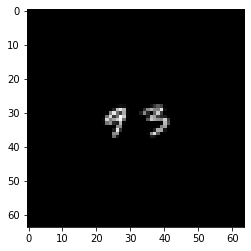

93101010


In [48]:
def predictPicture(img,model,n=16,m=16,fillStr='10'):
  numbers = [str(model.predict(j.reshape(1,16,16,1)).argmax()) \
                           for j in splitDigits(img,n=n,m=m)]
  return f'{"".join(numbers):t<5}'.replace('t',fillStr)
i = test[75]
plt.imshow(i,cmap="gray")
plt.show()
print(predictPicture(i,model))

q is 10071


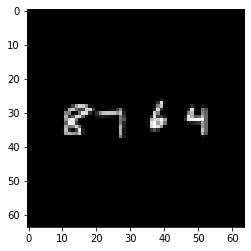

In [49]:
# predictions = [f'{"".join([str(model.predict(j.reshape(1,16,16,1)).argmax()) \
#                            for j in splitDigits(i,n=16,m=16)]):t<5}'.replace('t','10') \
#                for i in tqdm(test)]
predictions = []
q = 0
for i in tqdm(test):
  try:
    predictions.append(f'{"".join([str(model.predict(j.reshape(1,16,16,1)).argmax()) \
                           for j in splitDigits(i,n=16,m=16)]):t<5}'.replace('t','10'))
  except:
    print("q is",q)
    plt.imshow(i,cmap="gray")
    plt.show()
    predictions.append('0'*5)    
  q+=1
  

instance number 10071


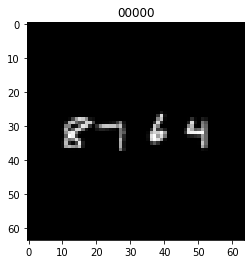

After spliting digits we have:


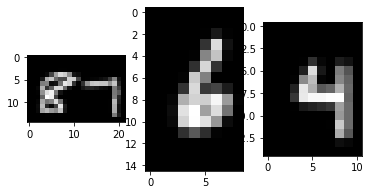

In [50]:
TestInstance = 10071
print(f"instance number {TestInstance}")
plt.imshow(test[TestInstance],cmap="gray")
plt.title(predictions[TestInstance])
plt.show()
print("After spliting digits we have:")
digits = splitDigits(test[TestInstance])
for i,p in enumerate(digits):
    plt.subplot(1,len(digits),i+1)
    plt.imshow(p,cmap="gray")
plt.show()

OK, this case seems not to have good response,
lets label it by hand :) 

In [51]:
predictions[10071] = '876410'

now lets convert data into csv file

In [52]:
!rm sample.csv
a = pd.DataFrame(enumerate(predictions),columns=['Id','Label']).to_csv("sample.csv",index=False)

In [38]:
!head sample.csv

Id,Label
0,910101010
1,017310
2,14083
3,010101010
4,467810
5,010101010
6,6921010
7,37101010
8,48267
